In [1]:
import numpy as np
import sympy as smp
from math import atan2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter

<center>

# **Four Bar Linkage**

<center>

A **four-bar mechanism** consists on four rigid bars connected by joints forming a closed loop, tipically with one bar being fixed (frame), an input bar, a coupled bar and an output bar. These rigid bars are connected via joints, leaving room for rotation.
These simple mechanisms can **transform rotational motion to linear motion, oscillatory or other type of motion**, depending on the lenght and location of the joints. The applications of this mechanical contraption has seen usages in a bunch of different fields; automotive, manufacturing, robotics, biomechanics and so on.

In this Notebook I'll solve and animate a four-bar mechanism given the lenght of the four bars and the location of the joints, for this purpose I'll follow an **OOP approach**, defining various classes: **Joint**, **Bar** and **FourBarLinkage**.


<center>
    <img src="four_bar_exercise.jpg" alt="Centered Exercise" width="600">


*Fig. I Four bar mechanism*
</center>

In [2]:
# Define the Joint() class

class Joint():
    
    def __init__(self, x= 0, y=0, fixed= False):
        self.x = x
        self.y = y
        self.fixed = fixed

# Define the Bar() class

class Bar():

    def __init__(self, joint1, joint2, lenght):
        self.joint1 = joint1
        self.joint2 = joint2
        self.lenght = lenght

    # Method that returns the bar orientation (between joints)
    def get_angles(self):
        delta_x = self.joint2.x - self.joint1.x
        delta_y = self.joint2.y - self.joint1.y
        return atan2(delta_y, delta_x)

In [12]:
# Define the FourBarMechanism() class

class FourBarMechanism():
    
    def __init__(self, A_pos, D_pos, L1, L2, L3, L4, ini_config= 'open'):

        self.joints = [
            Joint(A_pos[0], A_pos[1], fixed= True),
            Joint(0, 0,), # B Initially set to 0
            Joint(0, 0,), # C Initially set to 0
            Joint(D_pos[0], D_pos[1], fixed= True)
        ]

        self.bars = [
            Bar(self.joints[0], self.joints[1], L1), # AB (input bar)
            Bar(self.joints[1], self.joints[2], L2), # BC (coupler bar)
            Bar(self.joints[2], self.joints[3], L3), # CD (output bar)
            Bar(self.joints[3], self.joints[0], L4)  # DA (frame bar)
        ]

        self.input_angle = 0            # Set to 0 initially
        self.ini_config = ini_config
        self.previous_C = None          # Set to None initially

    def solve(self, input_angle):

        # Step 1: Compute the position of joint B given A and input_angle
        A = self.joints[0]
        B = self.joints[1]
        L1 = self.bars[0].lenght        # AB 
        theta = input_angle
        B.x = A.x + L1 * np.cos(theta)
        B.y = A.y + L1 * np.sin(theta)

        # Step 2: Compute the position of C using circle interception method
        C = self.joints[2]
        D = self.joints[3]
        L2 = self.bars[1].lenght        # BC 
        L3 = self.bars[2].lenght        # CD

        dx = D.x - B.x
        dy = D.y - B.y
        d = np.sqrt(dx**2 + dy**2)      # Distance between B and D

        # Check if the mechanism is possible (triangle inequality)

        if d > L2 + L3 or d < np.abs(L2 - L3):
            return False
    
        # Circle intersection equations
        a = (L2**2 - L3**2 + d**2) / (2 * d)    # Distance from B to the circle intersection
        h = np.sqrt(L2**2 - a**2)               # Height of intersection point

        mid_x = B.x + (a * dx) / d
        mid_y = B.y + (a * dy) / d

        # Possible positions to C

        C1_x = mid_x + (h * dy) / d
        C1_y = mid_y - (h * dx) / d
        C2_x = mid_x - (h * dy) / d
        C2_y = mid_y + (h * dx) / d

        # conditional statement to choose correct configuration

        if self.previous_C is None:
            if self.ini_config == 'open':
                C.x, C.y = C1_x, C1_y
            else:
                C.x, C.y = C2_x, C2_y
        
        else:
            C1 = np.array([C1_x, C1_y])
            C2 = np.array([C2_x, C2_y])
            dist1 = np.linalg.norm(C1 - self.previous_C)
            dist2 = np.linalg.norm(C2 - self.previous_C)
            C.x, C.y = (C1_x, C1_y) if dist1 < dist2 else (C2_x, C2_y)

        self.previous_C = np.array([C.x, C.y])

        return True
    
    def get_bar_positions(self):
        
        return [((bar.joint1.x, bar.joint1.y), (bar.joint2.x, bar.joint2.y)) for bar in self.bars]
    
    def animate(self, angle_range, interval= 50):
        
        # Define axis and figure

        fig, ax = plt.subplots()
        max_lenght = np.max([bar.lenght for bar in self.bars])
        ax.set_ylim(-1.5*max_lenght, 1.5*max_lenght)
        ax.set_xlim(-1.5*max_lenght, 1.5*max_lenght)
        ax.grid()

        # Create bar and joint graphics

        lines = [ax.plot([], [], 'b-', lw= 2)[0] for bar in self.bars]
        joints = [ax.plot([], [], 'ro')[0] for joint in self.joints]

        def init():
            for line in lines:
                line.set_data([], [])
            for joint in joints:
                joint.set_data([], [])
            return lines + joints
        

        def update_anim(frame):
            success = self.solve(angle_range[frame])

            if success:
                positions = self.get_bar_positions()
                for line, (start, end) in zip(lines, positions):
                    line.set_data([start[0], end[0]], [start[1], end[1]])
                for joint, j in zip(joints, self.joints):
                    joint.set_data([[j.x], [j.y]])
            return lines + joints
        
        anim = animation.FuncAnimation(
                        fig = fig,
                        func = update_anim,
                        init_func = init,
                        frames = len(angle_range),
                        interval = 50,
                        blit = True
        )

In [4]:
A = Joint(0, 0)
B = Joint(0, 1)

AB = Bar(A, B, 1)

print(np.rad2deg(AB.get_angles()))

90.0


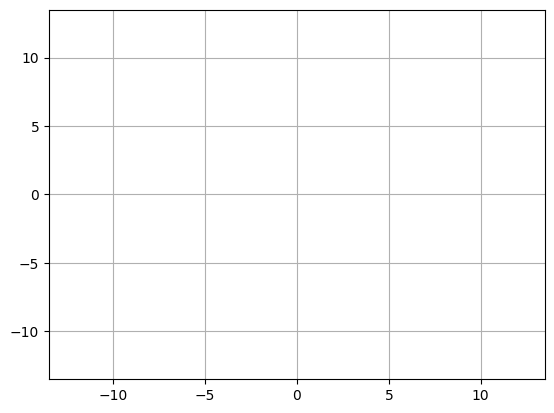

In [ ]:
mechanism = FourBarMechanism(
    A_pos = [0, 0],
    D_pos = [9, 0],
    L1 = 1,
    L2 = 9,
    L3 = 3,
    L4 = 9,
)
 
angles = np.linspace(0, 2*np.pi, 1001)
mechanism.animate(angle_range= angles)